In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
import zipfile



In [10]:
# Ruta al archivo ZIP
zip_path = "../stores/mlunlp-2024-ps-2.zip"

# Abrimos el ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Leer los archivos directamente desde el ZIP
    train_set_ind = pd.read_csv(zip_ref.open('train_personas.csv'))
    train_set_hog = pd.read_csv(zip_ref.open('train_hogares.csv'))
    test_set_ind = pd.read_csv(zip_ref.open('test_personas.csv'))
    test_set_hog = pd.read_csv(zip_ref.open('test_hogares.csv'))


In [5]:
train_set_hog.columns.values.tolist()

['id',
 'Clase',
 'Dominio',
 'P5000',
 'P5010',
 'P5090',
 'P5100',
 'P5130',
 'P5140',
 'Nper',
 'Npersug',
 'Ingtotug',
 'Ingtotugarr',
 'Ingpcug',
 'Li',
 'Lp',
 'Pobre',
 'Indigente',
 'Npobres',
 'Nindigentes',
 'Fex_c',
 'Depto',
 'Fex_dpto']

In [12]:
# La función summarize busca replicar el comando del mismo nombre que se utiliza en STATA.

def summarize(df, x, ponder):
    """
    Función que devuelve una tabla de estadísticas principales con ponderadores
    
    """
    mean_w = np.average(df[x], weights = df[ponder]) # Obtención de la media ponderada
    std_w = np.sqrt(
    np.average(
        (df[x] - np.average(df[x], weights=df[ponder]))**2,
        weights=df[ponder]
    ) * (len(df[x]) / (len(df[x]) - 1)) # Cálculo manual del desvío estandar ajustandolo por N-1 grados de libertad
)

    total_obs = df[ponder].sum() # Total de observaciones en función de la sumatoria de la columna del ponderador
    minimo = df[x].min() # El valor mínimo del conjunto de datos
    maximo = df[x].max() # El valor máximo del conjunto de datos
    return mean_w, std_w, total_obs, minimo, maximo

In [15]:
def subsidio(x):
    if x['P6585s1'] == 1:
        return 1
    elif x['P6585s2'] == 1:
        return 1
    elif x['P6585s3'] == 1:
        return 1
    elif x['P6585s4'] == 1:
        return 1
    else:
        return 0

In [14]:
def infancia(x):
    if x['P6040'] <= 15:
        return 1
    else:
        return 0

#### Conjunto de entrenamiento - Individuos

In [24]:
# Genero una dummy para varón y otra para mujer

train_set_ind_2 =  pd.get_dummies(train_set_ind, columns=['P6020'])
train_set_ind_2.rename(columns={'P6020_1':'Varon','P6020_2':'Mujer'}, inplace=True)

In [25]:
# Genero una dummy respecto si el individuo cobra subsidio o no

train_set_ind_2['subsidio'] = train_set_ind_2.apply(subsidio, axis=1)

In [26]:
# Genero una dummy identificatoria de infancia (sujeto con 15 años o menos)

train_set_ind_2['infancia'] = train_set_ind_2.apply(infancia, axis=1)

In [27]:
# Creo variable de ingreso de capital y/o pensiones

train_set_ind_2['ing_capital'] = train_set_ind_2['P7495'].apply(lambda x: 1 if x == 1 else 0)

In [28]:
# Me quedo con la máxima cantidad de años de educación del jefe de hogar

train_set_head = train_set_ind_2[train_set_ind_2['P6050'] == 1]

train_set_head = train_set_head[['id','P6210s1','P6800', 'Oc', 'Des', 'Ina']]

train_set_head = train_set_head.rename(columns={'P6210s1':'anios_educ_head','P6800':'hs_work_head', 'Oc':'oc_head', 'Des':'des_head', 'Ina':'ina_head'})

train_set_ind_2 = train_set_ind_2.merge(train_set_head, how='left', on='id')

train_set_ind_2

,id,Orden,Clase,Dominio,Estrato1,P6040,P6050,P6090,P6100,P6210,...,Varon,Mujer,subsidio,infancia,ing_capital,anios_educ_head,hs_work_head,oc_head,des_head,ina_head
0,8d0193e328305a042001a35f,2,1,MEDELLIN,2,38,2,1.0,1.0,3.0,...,0,1,1,0,0,11.0,60.0,1.0,NaN,NaN
1,8d0193e328305a042001a35f,5,1,MEDELLIN,2,3,3,NaN,NaN,2.0,...,1,0,0,1,0,11.0,60.0,1.0,NaN,NaN
2,8d0193e328305a042001a35f,1,1,MEDELLIN,2,41,1,1.0,1.0,5.0,...,1,0,1,0,0,11.0,60.0,1.0,NaN,NaN
3,8d0193e328305a042001a35f,4,1,MEDELLIN,2,3,3,NaN,NaN,2.0,...,1,0,0,1,0,11.0,60.0,1.0,NaN,NaN
4,8d0193e328305a042001a35f,3,1,MEDELLIN,2,11,3,NaN,NaN,4.0,...,1,0,0,1,0,11.0,60.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543104,5f037d9ddb23a0223d937b30,2,1,BOGOTA,2,24,2,1.0,1.0,5.0,...,0,1,1,0,0,10.0,48.0,1.0,NaN,NaN
543105,e575d8c70d587b3be3f45a6f,1,1,BOGOTA,3,36,1,1.0,1.0,6.0,...,0,1,0,0,0,8.0,60.0,1.0,NaN,NaN
543106,e575d8c70d587b3be3f45a6f,2,1,BOGOTA,3,41,2,1.0,1.0,6.0,...,1,0,0,0,0,8.0,60.0,1.0,NaN,NaN
543107,e575d8c70d587b3be3f45a6f,3,1,BOGOTA,3,8,3,NaN,NaN,3.0,...,1,0,0,1,0,8.0,60.0,1.0,NaN,NaN


In [29]:
train_set_ind_group = pd.pivot_table(data=train_set_ind_2, values=['Ingtotob', 'Ingtot', 'Varon', 'Mujer', 'subsidio', 'infancia', 'ing_capital',
                                                                  'anios_educ_head','hs_work_head','oc_head','des_head', 'ina_head'],
                                    index=['id', 'Dominio', 'Fex_c', 'Fex_dpto'],
                                    aggfunc= {'Ingtotob':'sum', 'Ingtot':'sum', 'Varon':'sum', 'Mujer':'sum', 'subsidio':'mean', 'infancia':'sum',
                                             'ing_capital':'first', 'anios_educ_head':'first','hs_work_head':'first','oc_head':'first','des_head':'first', 'ina_head':'first'}).reset_index()

#### Conjunto de prueba - Individuos

In [32]:
# Genero una dummy para varón y otra para mujer

test_set_ind_2 =  pd.get_dummies(test_set_ind, columns=['P6020'])
test_set_ind_2.rename(columns={'P6020_1':'Varon','P6020_2':'Mujer'}, inplace=True)

In [33]:
# Genero una dummy respecto si el individuo cobra subsidio o no

test_set_ind_2['subsidio'] = test_set_ind_2.apply(subsidio, axis=1)

In [34]:
# Genero una dummy identificatoria de infancia (sujeto con 15 años o menos)

test_set_ind_2['infancia'] = test_set_ind_2.apply(infancia, axis=1)

In [35]:
# Creo variable de ingreso de capital y/o pensiones

test_set_ind_2['ing_capital'] = test_set_ind_2['P7495'].apply(lambda x: 1 if x == 1 else 0)

In [36]:
# Me quedo con la máxima cantidad de años de educación del jefe de hogar

test_set_head = test_set_ind_2[test_set_ind_2['P6050'] == 1]

test_set_head = test_set_head[['id','P6210s1','P6800', 'Oc', 'Des', 'Ina']]

test_set_head = test_set_head.rename(columns={'P6210s1':'anios_educ_head','P6800':'hs_work_head', 'Oc':'oc_head', 'Des':'des_head', 'Ina':'ina_head'})

test_set_ind_2 = test_set_ind_2.merge(test_set_head, how='left', on='id')

test_set_ind_2

,id,Orden,Clase,Dominio,P6040,P6050,P6090,P6100,P6210,P6210s1,...,Varon,Mujer,subsidio,infancia,ing_capital,anios_educ_head,hs_work_head,oc_head,des_head,ina_head
0,3279230a4917cdf883df34cd,1,1,MEDELLIN,33,1,1.0,1.0,6.0,3.0,...,1,0,0,0,0,3.0,50.0,1.0,NaN,NaN
1,3279230a4917cdf883df34cd,3,1,MEDELLIN,7,3,NaN,NaN,3.0,NaN,...,0,1,0,1,0,3.0,50.0,1.0,NaN,NaN
2,3279230a4917cdf883df34cd,2,1,MEDELLIN,37,2,1.0,1.0,6.0,1.0,...,0,1,0,0,0,3.0,50.0,1.0,NaN,NaN
3,3279230a4917cdf883df34cd,4,1,MEDELLIN,5,3,NaN,NaN,2.0,NaN,...,1,0,0,1,0,3.0,50.0,1.0,NaN,NaN
4,01bd1f72445acc719d19bd25,1,1,MEDELLIN,27,1,1.0,1.0,5.0,11.0,...,1,0,0,0,1,11.0,48.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219639,95aca5f4d202450cdfc16c37,1,1,RIOHACHA,74,1,1.0,2.0,6.0,5.0,...,1,0,0,0,1,5.0,NaN,NaN,NaN,1.0
219640,95aca5f4d202450cdfc16c37,2,1,RIOHACHA,74,2,1.0,2.0,6.0,5.0,...,0,1,0,0,1,5.0,NaN,NaN,NaN,1.0
219641,95aca5f4d202450cdfc16c37,3,1,RIOHACHA,19,4,1.0,1.0,6.0,5.0,...,0,1,0,0,0,5.0,NaN,NaN,NaN,1.0
219642,95aca5f4d202450cdfc16c37,4,1,RIOHACHA,18,4,1.0,1.0,6.0,0.0,...,0,1,0,0,0,5.0,NaN,NaN,NaN,1.0


In [46]:
test_set_ind_2.columns.values

array(['id', 'Orden', 'Clase', 'Dominio', 'P6040', 'P6050', 'P6090',
       'P6100', 'P6210', 'P6210s1', 'P6240', 'Oficio', 'P6426', 'P6430',
       'P6510', 'P6545', 'P6580', 'P6585s1', 'P6585s2', 'P6585s3',
       'P6585s4', 'P6590', 'P6600', 'P6610', 'P6620', 'P6630s1',
       'P6630s2', 'P6630s3', 'P6630s4', 'P6630s6', 'P6800', 'P6870',
       'P6920', 'P7040', 'P7045', 'P7050', 'P7090', 'P7110', 'P7120',
       'P7150', 'P7160', 'P7310', 'P7350', 'P7422', 'P7472', 'P7495',
       'P7500s2', 'P7500s3', 'P7505', 'P7510s1', 'P7510s2', 'P7510s3',
       'P7510s5', 'P7510s6', 'P7510s7', 'Pet', 'Oc', 'Des', 'Ina',
       'Fex_c', 'Depto', 'Fex_dpto', 'Varon', 'Mujer', 'subsidio',
       'infancia', 'ing_capital', 'anios_educ_head', 'hs_work_head',
       'oc_head', 'des_head', 'ina_head', 'Ingtot'], dtype=object)

In [48]:
test_set_ind_group = pd.pivot_table(data=test_set_ind_2, values=['Varon', 'Mujer', 'subsidio', 'infancia', 'ing_capital',
                                                                  'anios_educ_head','hs_work_head','oc_head','des_head', 'ina_head'],
                                    index=['id', 'Dominio', 'Fex_c', 'Fex_dpto'],
                                    aggfunc= {'Varon':'sum', 'Mujer':'sum', 'subsidio':'mean', 'infancia':'sum',
                                             'ing_capital':'first', 'anios_educ_head':'first','hs_work_head':'first','oc_head':'first','des_head':'first', 'ina_head':'first'}).reset_index()

#### Conjunto de entrenamiento - Hogar

In [50]:
def tipo_vivienda(x):
    if x == 1 or x == 2:
        return 'Propia'
    elif x == 3 or x == 4:
        return 'Alquilada'
    elif x == 5:
        return 'Tomada'
    else:
        return 'Otro'

In [52]:
train_set_hog['P5090'] = train_set_hog['P5090'].apply(tipo_vivienda)
train_set_hog

,id,Clase,Dominio,P5000,P5010,P5090,P5100,P5130,P5140,Nper,...,Ingpcug,Li,Lp,Pobre,Indigente,Npobres,Nindigentes,Fex_c,Depto,Fex_dpto
0,8d0193e328305a042001a35f,1,MEDELLIN,4,2,Propia,NaN,400000.0,NaN,5,...,5.816661e+05,122809.534158,289878.247150,0,0,0,0,127.222038,5,146.251790
1,cf7491d7f2cc9c216bd009e7,1,MEDELLIN,5,4,Alquilada,NaN,NaN,250000.0,4,...,1.612500e+05,122809.534158,289878.247150,1,0,4,0,115.866093,5,93.080952
2,d90a57f64d2a84dbacbed2a5,1,MEDELLIN,4,2,Propia,NaN,700000.0,NaN,3,...,2.000000e+06,122809.534158,289878.247150,0,0,0,0,100.123276,5,89.637086
3,db34e387a94a783188ab3a33,1,MEDELLIN,3,1,Propia,NaN,450000.0,NaN,1,...,2.450000e+06,122809.534158,289878.247150,0,0,0,0,108.829812,5,95.584376
4,97bbef785824746ecab09c6f,1,MEDELLIN,4,3,Alquilada,NaN,NaN,500000.0,5,...,2.520000e+05,122809.534158,289878.247150,1,0,5,0,110.412859,5,124.560515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164955,0d168c0d27707687fcbf9b60,1,CALI,3,2,Alquilada,NaN,NaN,460000.0,3,...,2.824977e+05,127336.653858,280234.432107,0,0,0,0,73.088259,76,77.806334
164956,757f32d9b76aaa11eb93b4a6,1,BOGOTA,3,3,Alquilada,NaN,NaN,650000.0,8,...,3.600000e+05,123416.961118,280522.423188,0,0,0,0,413.891448,11,413.891448
164957,ff4ecf438cf2375b8d511645,1,BOGOTA,5,4,Propia,NaN,2000000.0,NaN,10,...,6.934544e+05,123416.961118,280522.423188,0,0,0,0,233.379248,11,233.379248
164958,5f037d9ddb23a0223d937b30,1,BOGOTA,2,1,Alquilada,NaN,NaN,400000.0,4,...,4.799466e+05,123416.961118,280522.423188,0,0,0,0,386.721150,11,386.721150


In [53]:
train_set_hog_2 =  pd.get_dummies(train_set_hog, columns=['P5090'])




In [57]:
train_set_hog_2['hacinamiento'] = train_set_hog_2['P5000']/train_set_hog_2['P5010']
train_set_hog_2

,id,Clase,Dominio,P5000,P5010,P5100,P5130,P5140,Nper,Npersug,...,Npobres,Nindigentes,Fex_c,Depto,Fex_dpto,P5090_Alquilada,P5090_Otro,P5090_Propia,P5090_Tomada,hacinamiento
0,8d0193e328305a042001a35f,1,MEDELLIN,4,2,NaN,400000.0,NaN,5,5,...,0,0,127.222038,5,146.251790,0,0,1,0,2.000000
1,cf7491d7f2cc9c216bd009e7,1,MEDELLIN,5,4,NaN,NaN,250000.0,4,4,...,4,0,115.866093,5,93.080952,1,0,0,0,1.250000
2,d90a57f64d2a84dbacbed2a5,1,MEDELLIN,4,2,NaN,700000.0,NaN,3,3,...,0,0,100.123276,5,89.637086,0,0,1,0,2.000000
3,db34e387a94a783188ab3a33,1,MEDELLIN,3,1,NaN,450000.0,NaN,1,1,...,0,0,108.829812,5,95.584376,0,0,1,0,3.000000
4,97bbef785824746ecab09c6f,1,MEDELLIN,4,3,NaN,NaN,500000.0,5,5,...,5,0,110.412859,5,124.560515,1,0,0,0,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164955,0d168c0d27707687fcbf9b60,1,CALI,3,2,NaN,NaN,460000.0,3,3,...,0,0,73.088259,76,77.806334,1,0,0,0,1.500000
164956,757f32d9b76aaa11eb93b4a6,1,BOGOTA,3,3,NaN,NaN,650000.0,8,8,...,0,0,413.891448,11,413.891448,1,0,0,0,1.000000
164957,ff4ecf438cf2375b8d511645,1,BOGOTA,5,4,NaN,2000000.0,NaN,10,10,...,0,0,233.379248,11,233.379248,0,0,1,0,1.250000
164958,5f037d9ddb23a0223d937b30,1,BOGOTA,2,1,NaN,NaN,400000.0,4,4,...,0,0,386.721150,11,386.721150,1,0,0,0,2.000000


#### Conjunto de prueba - Hogares

In [58]:
test_set_hog['P5090'] = test_set_hog['P5090'].apply(tipo_vivienda)

test_set_hog_2 =  pd.get_dummies(test_set_hog, columns=['P5090'])

test_set_hog_2['hacinamiento'] = test_set_hog_2['P5000']/test_set_hog_2['P5010']
test_set_hog_2

,id,Clase,Dominio,P5000,P5010,P5100,P5130,P5140,Nper,Npersug,Li,Lp,Fex_c,Depto,Fex_dpto,P5090_Alquilada,P5090_Otro,P5090_Propia,P5090_Tomada,hacinamiento
0,2a7ddc2779480d7f19834953,1,SANTA MARTA,4,3,NaN,400000.0,NaN,5,5,121449.452925,275594.029448,7.826095,47,7.528079,0,0,1,0,1.333333
1,a0c2e751e582fd49d564f308,1,SANTA MARTA,4,3,NaN,500000.0,NaN,6,6,121449.452925,275594.029448,15.002708,47,15.327736,1,0,0,0,1.333333
2,57273d19e8464a5ff66a582b,2,RURAL,3,1,NaN,250000.0,NaN,2,2,100763.337626,170886.447382,45.701877,17,50.394748,0,0,1,0,3.000000
3,418d052ff7878940ab938601,1,MEDELLIN,4,3,NaN,600000.0,NaN,5,5,122251.781628,294093.665341,70.318877,5,80.725068,0,0,1,0,1.333333
4,212a37fc17016a3c78f76852,1,MEDELLIN,5,2,1800000.0,2000000.0,NaN,2,2,123664.359813,293293.411227,91.241328,5,95.116936,0,0,1,0,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66163,e7d3c7cc62acd33867b7b7ee,1,BARRANQUILLA,3,2,NaN,NaN,450000.0,4,4,127610.370110,292192.080210,48.989768,8,48.415863,1,0,0,0,1.500000
66164,710db9f02de9c616f846c72e,1,CARTAGENA,3,2,NaN,NaN,100000.0,5,5,122811.614203,288078.106437,39.488634,13,32.499700,1,0,0,0,1.500000
66165,5a0d6b6fad06e4736fb6d95f,1,ARMENIA,3,2,NaN,NaN,250000.0,6,6,121282.133083,278659.892172,10.332009,63,9.719097,1,0,0,0,1.500000
66166,569496964b70185785b57789,1,PEREIRA,2,2,NaN,300000.0,NaN,5,5,121522.856805,287292.899913,16.470949,66,14.496007,1,0,0,0,1.000000


#### Merge

In [60]:
train_set_final = train_set_ind_group.merge(train_set_hog_2, how="inner", on="id")

In [61]:
test_set_final = test_set_ind_group.merge(test_set_hog_2, how="inner", on="id")

(164960, 42)

In [62]:
train_set_final['mayoria_infancia'] = train_set_final['infancia']/train_set_final['Nper']
test_set_final['mayoria_infancia'] = test_set_final['infancia']/test_set_final['Nper']


In [64]:
train_set_final.to_csv('../stores/train_set_final.csv')

In [65]:
test_set_final.to_csv('../stores/test_set_final.csv')

In [13]:
variables_independientes = ['Orden', 'mayoria_subsidio', 'mayoria_infancia']

# Diccionario para renombrar variables con nombres más descriptivos
etiquetas = {
    "share_varon": "Proporción de varones respecto al total del hogar",
    "share_mujer": "Proporción de mujeres respecto al total del hogar",
    "share_infancia": "Proporción de menores de 15 años respecto al total del hogar",
    "Orden": "Total de miembros del hogar",
    "subsidio": "proporción del hogar que recibe algún tipo de subsidio",
    "Ingtot_pc": "Ingreso per cápita del hogar",
    "lingtot_pc": "Logaritmo natural del ingreso per cápita del hogar"
}


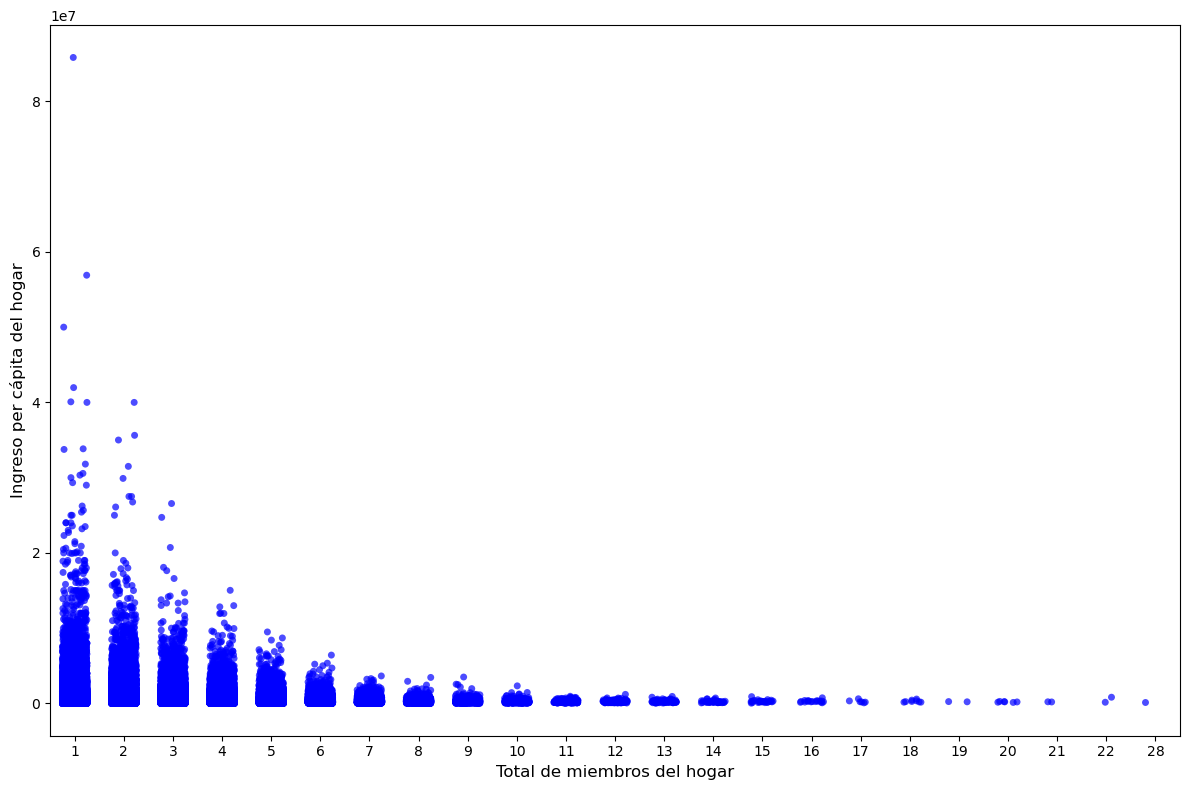

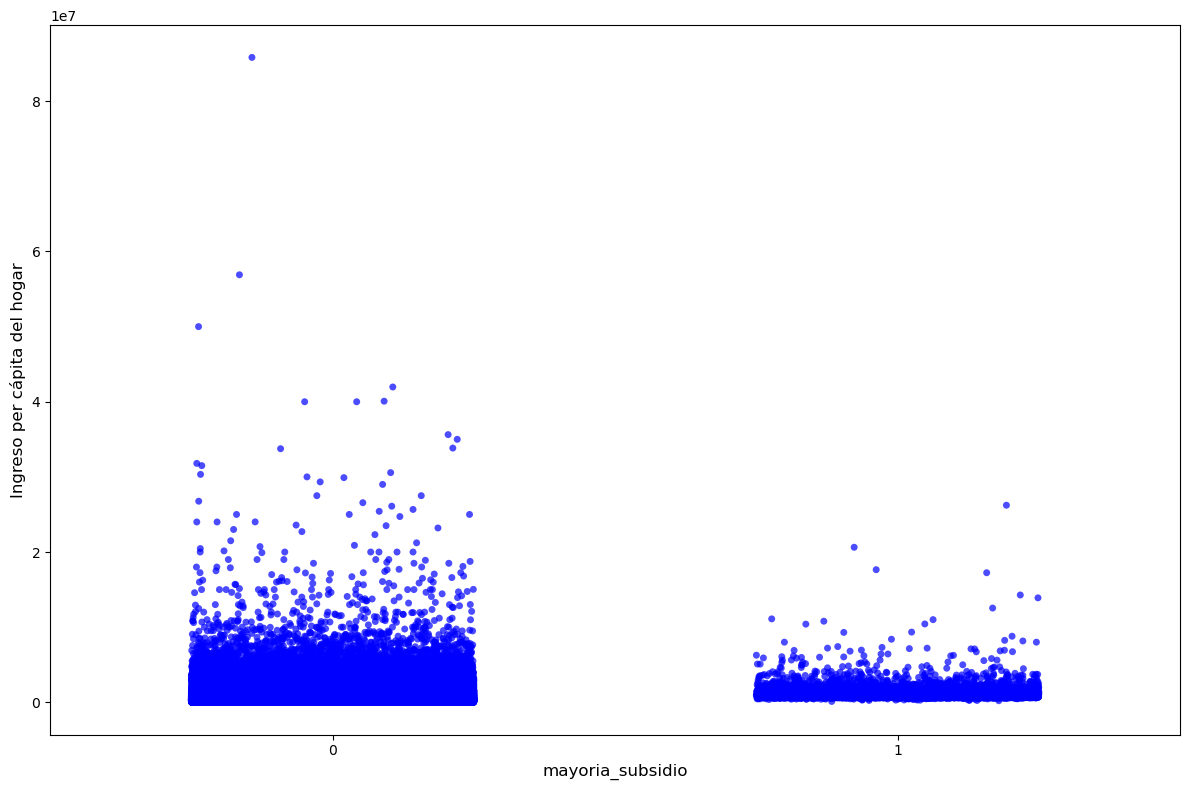

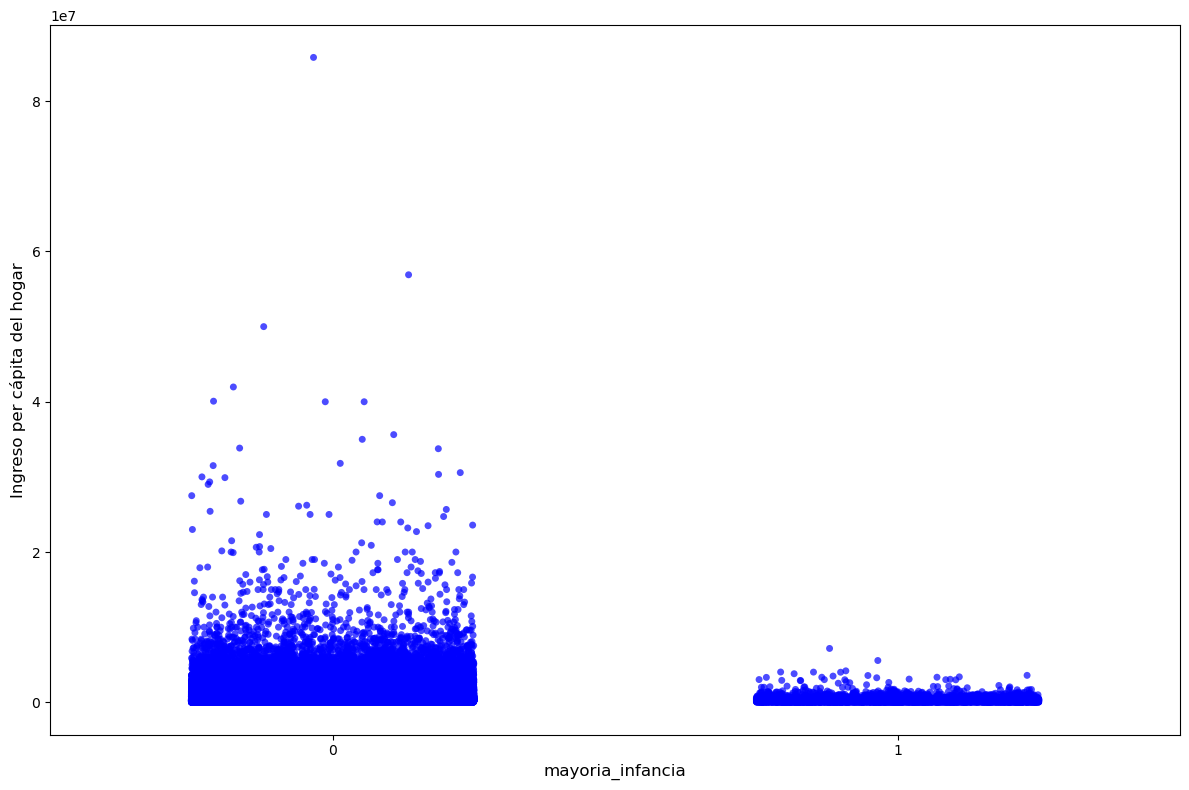

In [14]:
#Normal:

variable_dependiente = "Ingtot_pc"

for var in variables_independientes:
    plt.figure(figsize=(12, 8))  # Aumentar tamaño de la figura
    
    # Trazar el scatterplot (stripplot)
    sns.stripplot(
        x=train_set_ind_group[var], 
        y=train_set_ind_group[variable_dependiente], 
        alpha=0.7, 
        color="blue", 
        jitter=0.25  # Dispersa ligeramente los puntos para evitar solapamiento
    )
    
    # Etiquetas
    plt.xlabel(etiquetas.get(var, var), fontsize=12)
    plt.ylabel(etiquetas[variable_dependiente], fontsize=12)
    plt.yticks(fontsize=10)
    plt.tight_layout()  # Ajustar diseño
    
    # Mostrar el gráfico
    plt.show()

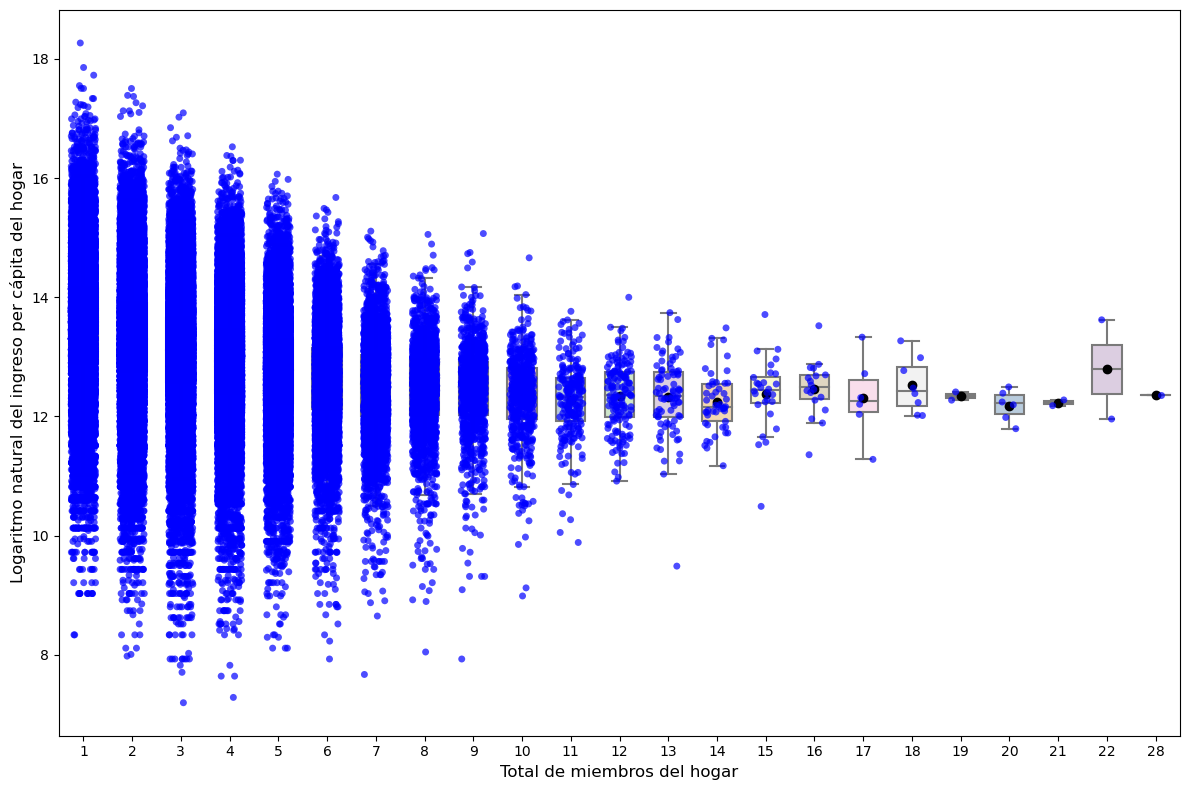

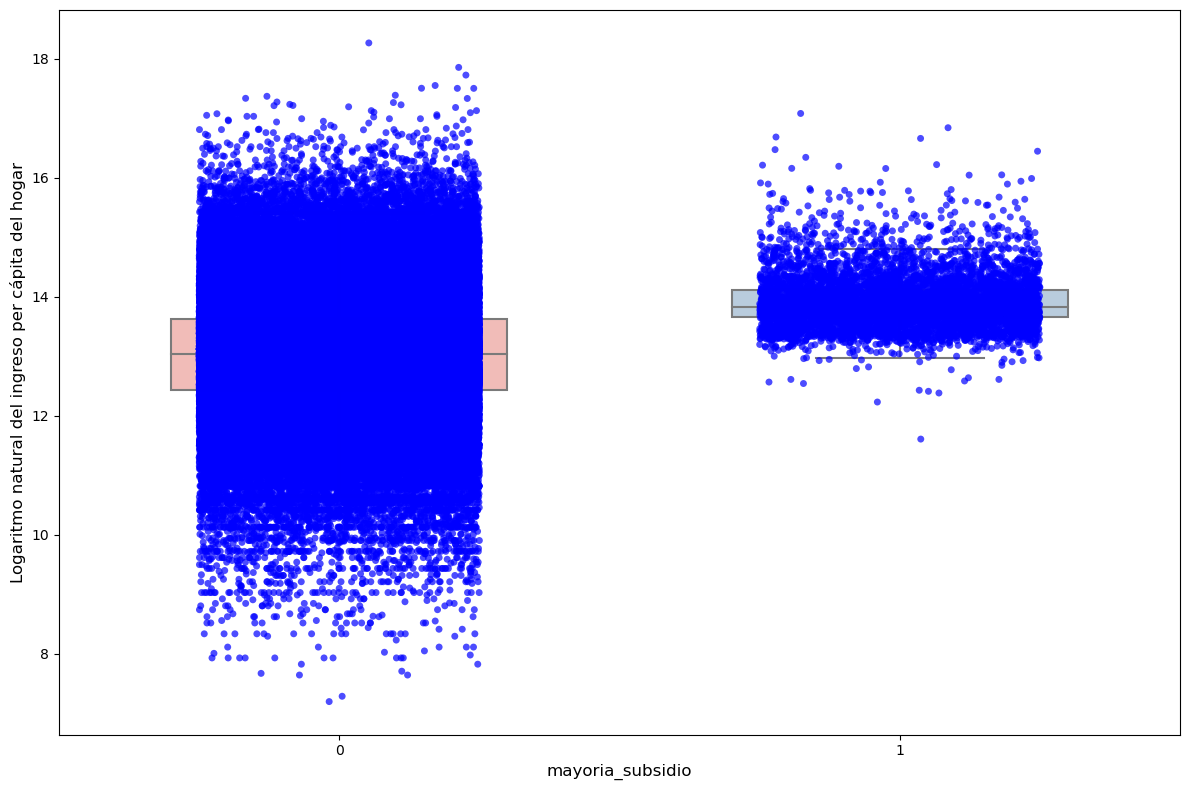

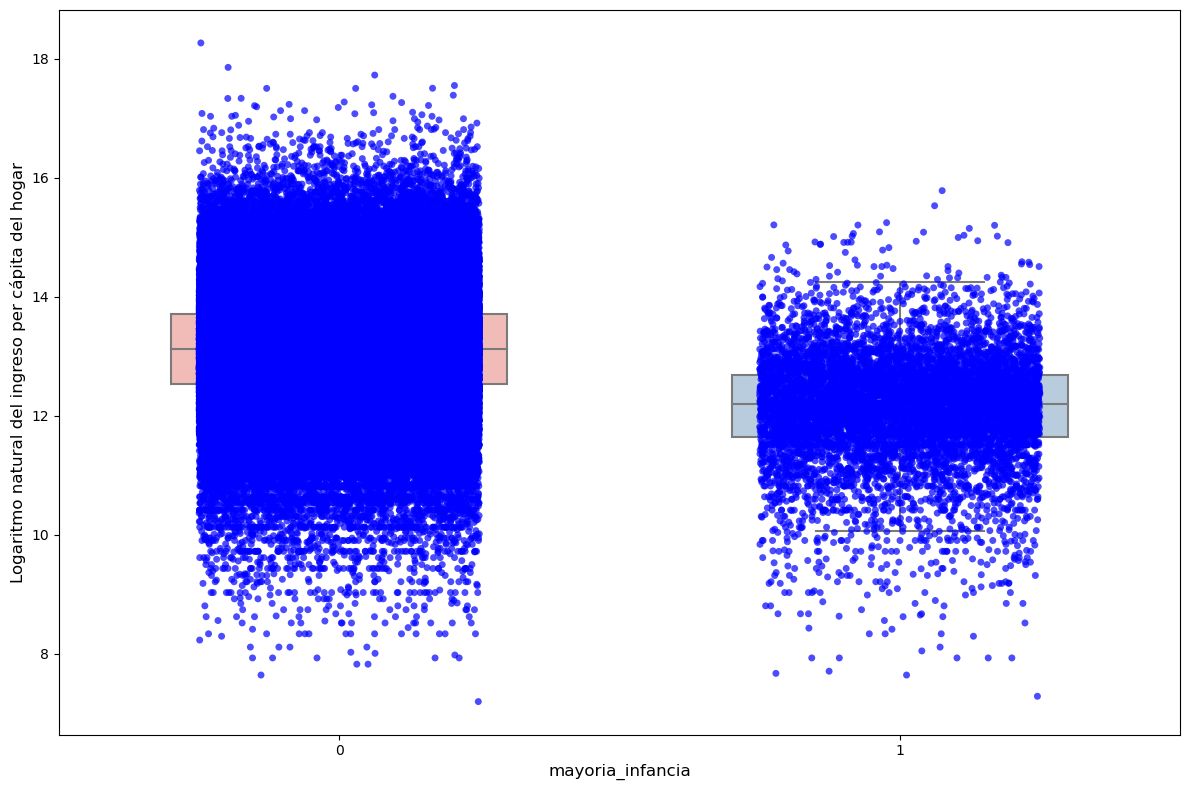

In [15]:
# En log natural

variable_dependiente = "lingtot_pc"


for var in variables_independientes:
    plt.figure(figsize=(12, 8))  # Aumentar tamaño de la figura
    
    # Trazar el boxplot detrás del scatterplot
    sns.boxplot(
        x=train_set_ind_group[var], 
        y=train_set_ind_group[variable_dependiente], 
        palette="Pastel1", 
        showmeans=True,  # Opcional, muestra la media
        meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"},
        width=0.6,  # Ajusta el ancho del boxplot
        fliersize=0  # Oculta los outliers para que no interfieran con el scatterplot
    )
    
    # Trazar el scatterplot (stripplot)
    sns.stripplot(
        x=train_set_ind_group[var], 
        y=train_set_ind_group[variable_dependiente], 
        alpha=0.7, 
        color="blue", 
        jitter=0.25  # Dispersa ligeramente los puntos para evitar solapamiento
    )
    
    # Etiquetas
    plt.xlabel(etiquetas.get(var, var), fontsize=12)
    plt.ylabel(etiquetas[variable_dependiente], fontsize=12)
    plt.yticks(fontsize=10)
    plt.tight_layout()  # Ajustar diseño
    
    # Mostrar el gráfico
    plt.show()